# Feature Extraction Notebook

Use the given data files, map 311 complaint types, number of crimes, and liquor sale license to geo-parsed cells over NYC. 

In [2]:
# Intall required packages
%%capture
!pip3 install rtree
!pip install pygeos
!pip install rtree
!pip install geopy
!pip install geopandas
!pip install geoplot
!pip install shapely

!pip install --upgrade --no-cache-dir gdown

In [3]:
# Import packages
import pandas as pd
import geopandas as gpd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import geoplot as gplt
import geoplot.crs as gcrs
import geopandas as gpd
import shapely
from shapely.geometry import Point,Polygon
import matplotlib.pyplot as plt

/usr/local/lib/python3.7/dist-packages/geopandas/_compat.py:115: UserWarning: The Shapely GEOS version (3.10.2-CAPI-1.16.0) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  shapely_geos_version, geos_capi_version_string


In [4]:
# Download csv files 
!gdown --id 1ONyLIYh_TtLblZ4n4ZlayyCpKU5CaqDh   # Crime
!gdown --id 18LHVepkWTGfNQ4oQMllzw9DBtjtxh7z3   # NYC 311
!gdown --id 1h2ktaaz_hs5EMh3Z_QMWTUTqBHlNeh0d   #Liquor License

/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=1ONyLIYh_TtLblZ4n4ZlayyCpKU5CaqDh
To: /content/Crime1.csv
100% 175M/175M [00:00<00:00, 214MB/s]
/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=18LHVepkWTGfNQ4oQMllzw9DBtjtxh7z3
To: /content/Copy of New_York_NY_311.csv
100% 3.10G/3.10G [00:13<00:00, 227MB/s]
/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading..

### 1. Freature Exploration in NYC 311

In [5]:
### Load the 3 Relevant CSV
crime_df = pd.read_csv('Crime1.csv')
ny311_df = pd.read_csv('Copy of New_York_NY_311.csv')
liquor_license_df = pd.read_csv('Updated_Liquor_Licenses.csv')

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: DtypeWarning: Columns (8,18,29,30) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


[Text(0.5, 1.0, 'Top 10 Complaint Type in NYC')]

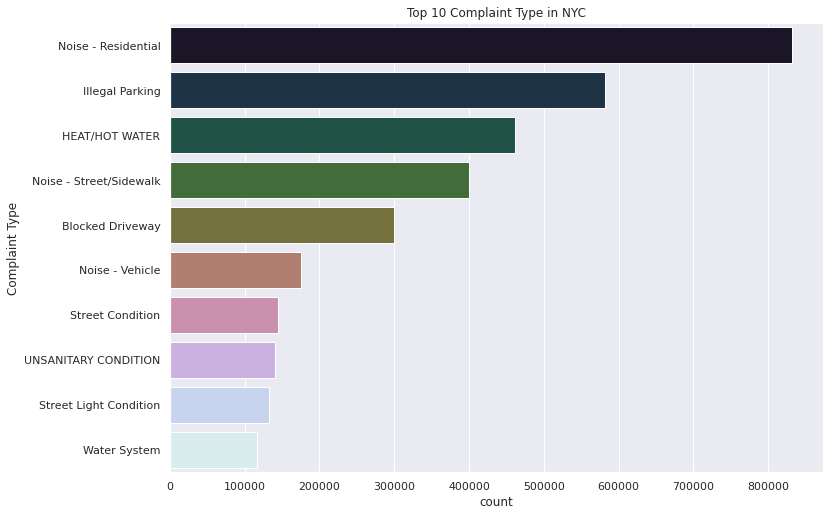

In [6]:
#top 10 complaint type in NYC 
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.countplot(y="Complaint Type", data=ny311_df, palette="cubehelix",
              order=ny311_df['Complaint Type'].value_counts().iloc[:10].index).set(title='Top 10 Complaint Type in NYC')

[Text(0.5, 1.0, 'Bottom 20 Complaint Type in NYC')]

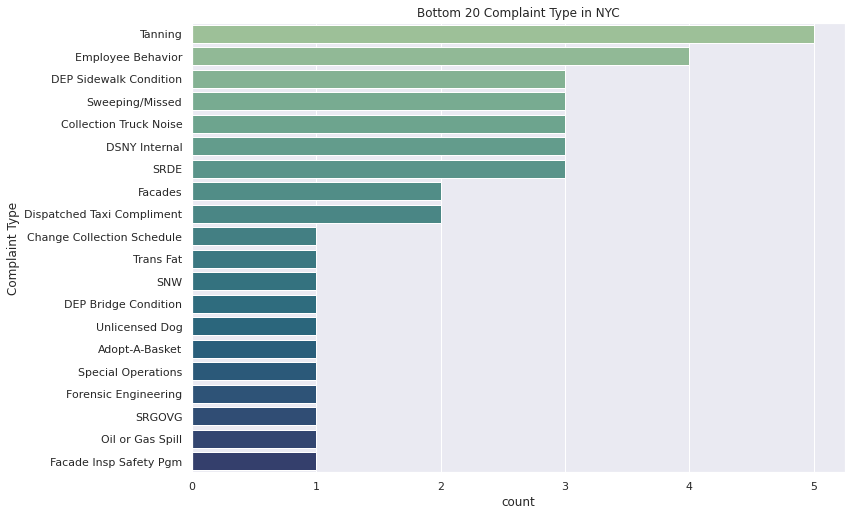

In [7]:
# Bottom 20 Freqent Complaint types
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.countplot(y="Complaint Type", data=ny311_df, palette="crest",
              order=ny311_df['Complaint Type'].value_counts().iloc[-20:].index).set(title='Bottom 20 Complaint Type in NYC')

[Text(0, 0.5, ''),
 Text(0.5, 0, ''),
 Text(0.5, 1.0, 'Complaint Distribution by Categorial Counts')]

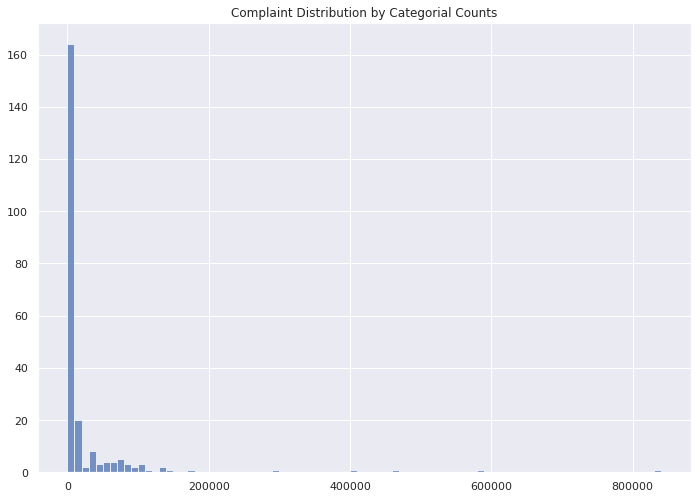

In [8]:
# Complaint Count distribution
sns.histplot(ny311_df['Complaint Type'].value_counts(),
             binwidth=10000,
             fill=True,
             ).set(title='Complaint Distribution by Categorial Counts', xlabel=None, ylabel=None)

### 2. Merge & Prep Data for Geo Referencing

In [13]:
# Clear up the kernal outputs
import warnings
warnings.filterwarnings('ignore')

In [14]:
# Download Relevant .shp files 
!gdown --id 1VXx_Tl-AZZb1oXpkl7bksXXkYk7nD9sn
!gdown --id 1fgCuTDHaE8qLkmEvD7SUMduQwExJM1iw
!gdown --id 1oPqS-dWWSXmHEnCUJpcweKBM_dabzNFS
!gdown --id 1UjvI6rWKzqS6yQtahP5BPqQ31YIKYTnz

/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=1VXx_Tl-AZZb1oXpkl7bksXXkYk7nD9sn
To: /content/geo_export_aef695bc-13cc-4e8c-b773-e2fc7ebcae80.dbf
100% 1.74G/1.74G [00:07<00:00, 226MB/s]
/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=1fgCuTDHaE8qLkmEvD7SUMduQwExJM1iw
To: /content/geo_export_aef695bc-13cc-4e8c-b773-e2fc7ebcae80.prj
100% 212/212 [00:00<00:00, 316kB/s]
/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it an

In [15]:
# Keep relevant columns
nyc_311_locs = ny311_df[['Latitude','Longitude', 'Complaint Type']]

In [23]:
# Liquor data re-factor & labeling
license_df = liquor_license_df[['Georeference']]
license_df['Latitude'] = license_df['Georeference'].apply(lambda x:float(x.split('(')[1].split(' ')[1].split(')')[0]))
license_df['Longitude'] = license_df['Georeference'].apply(lambda x:float(x.split('(')[1].split(' ')[0]))
license_df = license_df[['Latitude','Longitude']]
license_df['Complaint Type'] = 'Liquor_License'

In [20]:
# Crime data re-factor & labeling
crime_loc = crime_df[['Latitude','Longitude']]
crime_loc['Complaint Type'] = 'Crime'

In [21]:
# Keep track of all the columns
complaint_cat = ny311_df['Complaint Type'].unique().tolist()
complaint_cat = complaint_cat + ['Crime'] + ['Liquor_License']

In [25]:
# The big data frame we are using to map the points and cells
total_loc = pd.concat([nyc_311_locs, crime_loc, license_df])
total_loc = total_loc.reset_index()
total_loc.shape

(6374805, 4)

In [26]:
# Clean - anything out of the geo range of NYC, will not be kept
#### RUNTIME WARNING!!! ~5min
total_loc['keep'] = total_loc.apply(lambda row: 0 if(row.Longitude < -74.2555913 or row.Longitude > -73.70000906 or row.Latitude < 40.4961154 or row.Latitude > 40.91553278) else 1, axis=1) 
total_loc = total_loc.query("keep == 1")
total_loc.shape

(6374783, 5)

### 3. Geo-mapping of all the Features

In [27]:
# Create geo-referenced points based on coordinates
#### RUNTIME WARNING!!! ~3min
geometry = [Point(xy) for xy in zip(total_loc['Longitude'], total_loc['Latitude'])]
crs = 'EPSG:4326'
geo_df = gpd.GeoDataFrame(total_loc, crs = crs, geometry = geometry)

In [28]:
# Total area for the grid
xmin, ymin, xmax, ymax= geo_df.total_bounds

# How many cells across and down
n_cells=200
cell_size = (xmax-xmin)/n_cells

# Projection of the grid
crs = "+proj=sinu +lon_0=0 +x_0=0 +y_0=0 +a=6371007.181 +b=6371007.181 +units=m +no_defs"

# Create the cells in that grid, in a loop
grid_cells = []
for x0 in np.arange(xmin, xmax+cell_size, cell_size ):
    for y0 in np.arange(ymin, ymax+cell_size, cell_size):
        # bounds
        x1 = x0-cell_size
        y1 = y0+cell_size
        grid_cells.append( shapely.geometry.box(x0, y0, x1, y1)  )

# Create the cell DF that we will be merging our feature columns to 
cell = gpd.GeoDataFrame(grid_cells, columns=['geometry'], crs=crs)
cell.shape

(30351, 1)

In [29]:
# Loop through all the columns of features we are trying to match to cells created above
#### RUNTIME WARNING!!! ~8min
for i, category in enumerate(complaint_cat):

    # Filter to only that Complaint type 
    mask = geo_df['Complaint Type'] == category
    sub_geo_df = geo_df[mask]
    
    sub_geo_df = sub_geo_df[['geometry']]

    # Check all the points, match them to each cell that contains the point
    merged = gpd.sjoin(cell, sub_geo_df,  how='right', predicate='contains')
    merged[category] = 1
    
    # Count the occurence in every unique cell
    dissolve = merged.dissolve(by="index_left", aggfunc="count")
    dissolve.index = dissolve.index.map(int)

    # Add the information back to the cell DF
    cell.loc[dissolve.index, category] = dissolve[category].values

    # Display progress
    print(i, category, cell[category].sum())

0 Blocked Driveway 298691.0
1 Noise - Residential 829912.0
2 Noise - Helicopter 40340.0
3 Noise - Commercial 106732.0
4 HEAT/HOT WATER 461068.0
5 Illegal Parking 576393.0
6 Street Condition 128322.0
7 Rodent 71921.0
8 Noise - Street/Sidewalk 398273.0
9 Illegal Fireworks 70821.0
10 PLUMBING 83034.0
11 DOOR/WINDOW 55684.0
12 Sidewalk Condition 53647.0
13 Taxi Complaint 9338.0
14 Traffic Signal Condition 50425.0
15 Dirty Conditions 56464.0
16 Building/Use 36791.0
17 Noise 97838.0
18 Sewer 65705.0
19 Drinking 6665.0
20 Street Light Condition 84453.0
21 Noise - Vehicle 173852.0
22 Animal-Abuse 14892.0
23 Elevator 30877.0
24 Derelict Vehicles 74841.0
25 Dead/Dying Tree 18717.0
26 Non-Emergency Police Matter 106237.0
27 Homeless Encampment 172.0
28 WATER LEAK 56963.0
29 UNSANITARY CONDITION 139886.0
30 General Construction/Plumbing 74805.0
31 Boilers 6678.0
32 Street Sign - Missing 9820.0
33 Water System 115547.0
34 For Hire Vehicle Complaint 17262.0
35 Food Establishment 18185.0
36 Special P

In [30]:
# Now 229 columns for each cell are created, those doesn't have any occurance within the cell (was 'NaN') are filled with 0
cell = cell.fillna(0)

In [31]:
# Save the file
#### RUNTIME WARNING!!! ~8min

cell.to_file("cell_agg_all_NYC.geojson", driver='GeoJSON') 

# To read, do <gpd.read_file("cell_agg_Complaints_Crimes.geojson")>